## Imports

In [1]:
# import plaidml.keras
# plaidml.keras.install_backend()
import wandb
import os
import multiprocessing
import rasterio
import tensorflow as tf
from glob import glob
import pickle
import numpy as np
import os
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import layers
from tensorflow_addons.metrics import F1Score, HammingLoss
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy

import keras
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
np.set_printoptions(suppress=True)
np.set_printoptions(precision=6)
print(tf.__version__)

Using TensorFlow backend.


2.4.0


### Test with Simple CNN and Data Loader 

In [2]:
import boto3
import rasterio as rio
import numpy as np
import io

In [3]:
from dataloader import DataLoader

wandb: WARNING Keras version 2.2.4 is not fully supported. Required keras >= 2.4.0


In [4]:
import wandb
from wandb.keras import WandbCallback 

wandb.init(project='project_canopy', sync_tensorboard=True)
config = wandb.config

wandb: Currently logged in as: margauxmforsythe (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [5]:
class DataLoader:
    def __init__(self,
                 training_dir="/Users/margauxmforstyhe/Desktop/DatasetV2_PC/chips/cloudfree-merge-polygons/dataset_v2/",
                 label_file_path_train="labels_test_v1.csv",
                 label_file_path_val="labels_val.csv",
#                  bucket_name='canopy-production-ml',
                 data_extension_type='.tif',
                 bands=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
                 augment=False,
                 enable_shuffle=False,
                 training_data_shuffle_buffer_size=1000,
                 training_data_batch_size=20,
                 enable_data_prefetch=False,
                 data_prefetch_size=tf.data.experimental.AUTOTUNE,
                 num_parallel_calls=tf.data.AUTOTUNE,
                 output_shape=(tf.float32, tf.float32)):

#         self.bucket_name = bucket_name

        self.label_file_path_train = label_file_path_train
        self.label_file_path_val = label_file_path_val

        print(f"label_file_path_train: {self.label_file_path_train}")
        print(f"labels_file_val: {self.label_file_path_val}")
        self.labels_file_train = pd.read_csv(self.label_file_path_train)
        self.labels_file_val = pd.read_csv(self.label_file_path_val)
        self.training_filenames = self.labels_file_train.paths.to_list()

        self.labels_file_val = pd.read_csv(self.label_file_path_val)
        self.validation_filenames = self.labels_file_val.paths.to_list()

        self.bands = bands
        self.augment = augment
        self.local_path_train = training_dir

        self.enable_shuffle = enable_shuffle
        if training_data_shuffle_buffer_size is not None:
            self.training_data_shuffle_buffer_size = training_data_shuffle_buffer_size

        self.num_parallel_calls = num_parallel_calls
        self.enable_data_prefetch = enable_data_prefetch
        self.data_prefetch_size = data_prefetch_size
        self.data_extension_type = data_extension_type
        self.output_shape = output_shape

        self.training_data_batch_size = training_data_batch_size

        self.build_training_dataset()
        self.build_validation_dataset()

    def build_training_dataset(self):
        # Tensor of all the paths to the images
        self.training_dataset = tf.data.Dataset.from_tensor_slices(self.training_filenames)

        # If data augmentation
        if self.augment is True:
            # https://stackoverflow.com/questions/61760235/data-augmentation-on-tf-dataset-dataset
            print("Data augmentation enabled")
            
            self.training_dataset = self.training_dataset.map((
                lambda x: tf.py_function(self.process_path, [x], self.output_shape)),
                num_parallel_calls=self.num_parallel_calls).map(
            lambda image, label: (tf.image.random_flip_left_right(image), label)
            ).map(
            lambda image, label: (tf.image.random_flip_up_down(image), label)
            ).repeat(3)
            
            self.length_training_dataset = len(self.training_filenames) * 3
            print(f"Training on {self.length_training_dataset} images")
        else:
            print("No data augmentation. Please set augment to True if you want to augment training dataset")
            self.training_dataset = self.training_dataset.map((
                lambda x: tf.py_function(self.process_path, [x], self.output_shape)),
                num_parallel_calls=self.num_parallel_calls)
            self.length_training_dataset = len(self.training_filenames)
            print(f"Training on {self.length_training_dataset} images")

        # Randomly shuffles the elements of this dataset.
        # This dataset fills a buffer with `buffer_size` elements, then randomly
        # samples elements from this buffer, replacing the selected elements with new
        # elements. For perfect shuffling, a buffer size greater than or equal to the
        # full size of the dataset is required.
        if self.enable_shuffle is True:
            if self.training_data_shuffle_buffer_size is None:
                self.training_data_shuffle_buffer_size = len(self.length_training_dataset)
            self.training_dataset = self.training_dataset.shuffle(self.training_data_shuffle_buffer_size,
                                                                  reshuffle_each_iteration=True
                                                                  # controls whether the shuffle order should be different for each epoch
                                                                  )

        if self.training_data_batch_size is not None:
            # Combines consecutive elements of this dataset into batches
            self.training_dataset = self.training_dataset.batch(self.training_data_batch_size)

        # Most dataset input pipelines should end with a call to `prefetch`. This
        # allows later elements to be prepared while the current element is being
        # processed. This often improves latency and throughput, at the cost of
        # using additional memory to store prefetched elements.
        if self.enable_data_prefetch:
            self.training_dataset = self.training_dataset.prefetch(self.data_prefetch_size)

    def build_validation_dataset(self):
        self.validation_dataset = tf.data.Dataset.from_tensor_slices(list(self.validation_filenames))
        self.validation_dataset = self.validation_dataset.map(
            (lambda x: tf.py_function(self.process_path, [x], self.output_shape)),
            num_parallel_calls=self.num_parallel_calls)

        self.validation_dataset = self.validation_dataset.batch(self.training_data_batch_size)
        print(f"Validation on {len(self.validation_filenames)} images ")

    def read_image(self, path_img):
        path_to_img = self.local_path_train + "/" + path_img.numpy().decode()
        train_img = np.transpose(rasterio.open(path_to_img).read(self.bands), (1, 2, 0))
        # Normalize image
        train_img = tf.image.convert_image_dtype(train_img, tf.float32)
        return train_img
    

    def get_label_from_csv(self, path_img):
        # testing if path in the training csv file or in the val one
        if path_img.numpy().decode() in self.labels_file_train.paths.to_list():
            ### Training csv
            # path_img is a tf.string and needs to be converted into a string using .numpy().decode()
            id = int(self.labels_file_train[self.labels_file_train.paths == path_img.numpy().decode()].index.values[0])
            # The list of labels (e.g [0,1,0,0,0,0,0,0,0,0] is grabbed from the csv file on the row where the s3 path is
            label = self.labels_file_train.drop('paths', 1).iloc[int(id)].to_list()
        else:
            ### Validation csv
            # path_img is a tf.string and needs to be converted into a string using .numpy().decode()
            id = int(self.labels_file_val[self.labels_file_val.paths == path_img.numpy().decode()].index.values[0])
            # The list of labels (e.g [0,1,0,0,0,0,0,0,0,0] is grabbed from the csv file on the row where the s3 path is
            label = self.labels_file_val.drop('paths', 1).iloc[int(id)].to_list()
        return label

    # Function used in the map() and returns the image and label corresponding to the file_path input
    def process_path(self, file_path):
        label = self.get_label_from_csv(file_path)
        img = self.read_image(file_path)
        return img, label

In [6]:
# Variables definition
config.batch_size = 64
config.learning_rate = 0.001
config.label_file_path_train="data/new_train_labels_v5_10_percent.csv" # labels_1_4_train_v2
config.label_file_path_val="data/new_val_labels_v5_10000.csv"
config.loss = SigmoidFocalCrossEntropy() # tf.keras.losses.BinaryCrossentropy(from_logits=False)
config.optimizer = keras.optimizers.Adam(config.learning_rate)
config.input_shape = (100,100,5)
config.numclasses=5

config.augment = False
config.enable_shuffle=True

print(f"batch size {config.batch_size}, learning_rate {config.learning_rate}, augment {config.augment}")

batch size 64, learning_rate 0.001, augment False


In [7]:
bands = [2, 3, 4, 8, 18]
gen = DataLoader(label_file_path_train=config.label_file_path_train, # test labels_test_v1 TODO use s3 paths
                label_file_path_val=config.label_file_path_val, # or val_all
#                 bucket_name='canopy-production-ml/chips/cloudfree-merge-polygons/dataset_v2',
                data_extension_type='.tif',
                bands=bands,
                augment=config.augment,
                enable_shuffle=config.enable_shuffle,
                training_data_batch_size=config.batch_size,
                enable_data_prefetch=True
                )


label_file_path_train: data/new_train_labels_v5_10_percent.csv
labels_file_val: data/new_val_labels_v5_10000.csv
No data augmentation. Please set augment to True if you want to augment training dataset
Training on 21428 images
Validation on 10714 images 


In [8]:
def plot_learningCurve(history):
  # Plot training & validation accuracy values
  plt.plot(history.history['accuracy'])
#   plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
#   plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train'], loc='upper left')
  plt.show()
  
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Val'], loc='upper left')
  plt.show()

  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Val'], loc='upper left')
  plt.show()




## PREPRODUCTION Candidate: ResNet50 pretrained on ImageNet

### Build model

In [9]:
  def define_model(numclasses, input_shape, starting_checkpoint=None, lcl_chkpt_dir=None):
        # parameters for CNN
        input_tensor = Input(shape=input_shape)

        # introduce a additional layer to get from bands to 3 input channels
        input_tensor = Conv2D(3, (1, 1))(input_tensor)

        base_model_resnet50 = tf.keras.applications.ResNet50(include_top=False,
                                                          weights='imagenet',
                                                          input_shape=(100, 100, 3))
        base_model = tf.keras.applications.ResNet50(include_top=False,
                                                 weights=None,
                                                 input_tensor=input_tensor)

        for i, layer in enumerate(base_model_resnet50.layers):
            # we must skip input layer, which has no weights
            if i == 0:
                continue
            base_model.layers[i + 1].set_weights(layer.get_weights())

        # add a global spatial average pooling layer
        top_model = base_model.output
        top_model = GlobalAveragePooling2D()(top_model)

        # let's add a fully-connected layer
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        # and a logistic layer  
        predictions = Dense(numclasses, activation="sigmoid")(top_model)
        

        # this is the model we will train
        model = Model(inputs=base_model.input, outputs=predictions)
#         model.summary()

        return model

In [10]:
def Simple_CNN(numclasses, input_shape): #TODO use a more complex CNN
        model = Sequential([
            layers.Input(input_shape),
            layers.Conv2D(16, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(32, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(64, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(numclasses, activation="softmax")
        ])
        return model

In [11]:
# def define_model_VGG16(numclasses, input_shape): 
#     model = Sequential([
#         layers.Input(input_shape),
#         layers.Conv2D(64, 3, padding='same', activation='relu'),
#         layers.Conv2D(64, 3, padding='same', activation='relu'),
#         layers.MaxPooling2D(),
#         layers.Conv2D(128, 3, padding='same', activation='relu'),
#         layers.Conv2D(128, 3, padding='same', activation='relu'),
#         layers.MaxPooling2D(),
#         layers.Conv2D(256, 3, padding='same', activation='relu'),
#         layers.Conv2D(256, 3, padding='same', activation='relu'),
#         layers.Conv2D(256, 3, padding='same', activation='relu'),
#         layers.MaxPooling2D(),
#         layers.Conv2D(512, 3, padding='same', activation='relu'),
#         layers.Conv2D(512, 3, padding='same', activation='relu'),
#         layers.Conv2D(512, 3, padding='same', activation='relu'),
#         layers.MaxPooling2D(),
#         layers.Conv2D(512, 3, padding='same', activation='relu'),
#         layers.Conv2D(512, 3, padding='same', activation='relu'),
#         layers.Conv2D(512, 3, padding='same', activation='relu'),
#         layers.MaxPooling2D(),
#         layers.Flatten(),
#         layers.Dense(256, activation='relu'),
#         layers.Dense(numclasses, activation="softmax")
#     ])
#     return model
# model_2 = define_model(config.numclasses, config.input_shape)
# model_2.summary()

In [12]:
random_id = random.randint(1,10001) 

model_checkpoint_callback_loss = tf.keras.callbacks.ModelCheckpoint(
  filepath= f'checkpoint_loss.h5',
  format='h5',
  verbose=1,
  save_weights_only=True,
  monitor='val_loss',
  mode='min',
  save_best_only=True)

model_checkpoint_callback_recall = tf.keras.callbacks.ModelCheckpoint(
  filepath= f'checkpoint_recall.h5',
  format='h5',
  verbose=1,
  save_weights_only=True,
  monitor='val_recall',
  mode='max',
  save_best_only=True)

model_checkpoint_callback_precision = tf.keras.callbacks.ModelCheckpoint(
  filepath= f'checkpoint_precision.h5',
  format='h5',
  verbose=1,
  save_weights_only=True,
  monitor='val_precision',
  mode='max',
  save_best_only=True)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_precision', mode='max', patience=20, verbose=1)
    
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_precision',mode='max', factor=0.1,patience=5, min_lr=0.000001, verbose=1)
wandb_callback = WandbCallback()

callbacks_list = [model_checkpoint_callback_recall, early_stop,reduce_lr, WandbCallback()]

model = Simple_CNN(config.numclasses, config.input_shape)
# model = define_model(config.numclasses, config.input_shape)

# loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), # Computes the cross-entropy loss between true labels and predicted labels.
# Focal loss instead of class weights: https://www.dlology.com/blog/multi-class-classification-with-focal-loss-for-imbalanced-datasets/
model.compile(loss=BinaryCrossentropy(),
                  # https://www.tensorflow.org/addons/api_docs/python/tfa/losses/SigmoidFocalCrossEntropy
                  optimizer=tf.keras.optimizers.Adam(config.learning_rate),
                  metrics=[tf.metrics.BinaryAccuracy(name='accuracy'),
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Precision(class_id=1,name='ISL_precision'),
                           # Computes the precision of the predictions with respect to the labels.
                           tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.Recall(class_id=1,name='ISL_recall'),
                           # Computes the recall of the predictions with respect to the labels.
                           F1Score(num_classes=config.numclasses, name="f1_score"),
#                            tf.keras.metrics.AUC(name="auc")
                           ]
                  )


### Start training

In [14]:
for img, label in gen.training_dataset:
    print(img.shape)
    print(label.shape)
    break
for img, label in gen.validation_dataset:
    print(img.shape)
    print(label.shape)
    break

(64, 100, 100, 5)
(64, 5)
(64, 100, 100, 5)
(64, 5)


In [15]:
epochs = 30
history = model.fit(gen.training_dataset, 
                    validation_data=gen.validation_dataset, 
                    epochs=epochs, 
                    callbacks=callbacks_list
                   ) 
model.save('./model.h5')

Epoch 1/30
335/335 [==============================] - 200s 579ms/step - loss: 0.3612 - accuracy: 0.8568 - precision: 0.4747 - ISL_precision: 0.4745 - recall: 0.1568 - ISL_recall: 0.3367 - f1_score: 0.1437 - val_loss: 0.3207 - val_accuracy: 0.8780 - val_precision: 0.5529 - val_ISL_precision: 0.5587 - val_recall: 0.5040 - val_ISL_recall: 0.9376 - val_f1_score: 0.2474

Epoch 00001: val_recall improved from -inf to 0.50401, saving model to checkpoint_recall.h5
Epoch 2/30
335/335 [==============================] - 212s 620ms/step - loss: 0.3266 - accuracy: 0.8715 - precision: 0.5655 - ISL_precision: 0.5680 - recall: 0.3890 - ISL_recall: 0.7339 - f1_score: 0.3002 - val_loss: 0.2954 - val_accuracy: 0.9002 - val_precision: 0.6586 - val_ISL_precision: 0.6643 - val_recall: 0.5420 - val_ISL_recall: 0.8933 - val_f1_score: 0.3633

Epoch 00002: val_recall improved from 0.50401 to 0.54204, saving model to checkpoint_recall.h5
Epoch 3/30
335/335 [==============================] - 220s 641ms/step - los

In [16]:
model.evaluate(gen.validation_dataset) 

168/168 [==============================] - 59s 351ms/step - loss: 0.2774 - accuracy: 0.9241 - precision: 0.7074 - ISL_precision: 0.8050 - recall: 0.7463 - ISL_recall: 0.9016 - f1_score: 0.4848


[0.2773585915565491,
 0.9240806102752686,
 0.7074321508407593,
 0.8050346970558167,
 0.7462666034698486,
 0.9016110301017761,
 array([0.671849, 0.848233, 0.224215, 0.207275, 0.472472], dtype=float32)]

Evaluation

In [17]:
model_test = Simple_CNN(config.numclasses, config.input_shape)
model_test.compile(loss=BinaryCrossentropy(),
                  # https://www.tensorflow.org/addons/api_docs/python/tfa/losses/SigmoidFocalCrossEntropy
                  optimizer=tf.keras.optimizers.Adam(config.learning_rate),
                  metrics=[tf.metrics.BinaryAccuracy(name='accuracy'),
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Precision(class_id=1,name='ISL_precision'),
                           # Computes the precision of the predictions with respect to the labels.
                           tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.Recall(class_id=1,name='ISL_recall'),
                           # Computes the recall of the predictions with respect to the labels.
                           F1Score(num_classes=config.numclasses, name="f1_score"),
#                            tf.keras.metrics.AUC(name="auc")
                           ]
                  )
model_test.load_weights("checkpoint_recall.h5")
model_test.evaluate(gen.validation_dataset) 

168/168 [==============================] - 60s 349ms/step - loss: 0.2640 - accuracy: 0.9273 - precision: 0.7196 - ISL_precision: 0.7977 - recall: 0.7541 - ISL_recall: 0.9177 - f1_score: 0.5020


[0.26849085092544556,
 0.9255180358886719,
 0.7126180529594421,
 0.7954602241516113,
 0.7512444853782654,
 0.9174338579177856,
 array([0.674727, 0.846346, 0.242718, 0.224796, 0.472046], dtype=float32)]

In [18]:
model_test = tf.keras.models.load_model('./model.h5')
model_test.evaluate(gen.validation_dataset) 

168/168 [==============================] - 60s 353ms/step - loss: 0.2774 - accuracy: 0.9241 - precision: 0.7074 - ISL_precision: 0.8050 - recall: 0.7463 - ISL_recall: 0.9016 - f1_score: 0.4848


[0.2773585915565491,
 0.9240806102752686,
 0.7074321508407593,
 0.8050346970558167,
 0.7462666034698486,
 0.9016110301017761,
 array([0.671849, 0.848233, 0.224215, 0.207275, 0.472472], dtype=float32)]

In [19]:
model_test = tf.keras.models.load_model('./model.h5')
model_test.load_weights("checkpoint_recall.h5")
model_test.evaluate(gen.validation_dataset)

168/168 [==============================] - 60s 351ms/step - loss: 0.2685 - accuracy: 0.9255 - precision: 0.7126 - ISL_precision: 0.7955 - recall: 0.7512 - ISL_recall: 0.9174 - f1_score: 0.4921


[0.26849085092544556,
 0.9255180358886719,
 0.7126180529594421,
 0.7954602241516113,
 0.7512444853782654,
 0.9174338579177856,
 array([0.674727, 0.846346, 0.242718, 0.224796, 0.472046], dtype=float32)]

In [20]:
class TestDataLoader:
    def __init__(self,
                 training_dir="/Users/margauxmforstyhe/Desktop/DatasetV2_PC/chips/cloudfree-merge-polygons/dataset_v2/",
                 label_file_path_test="labels_test.csv",
                 data_extension_type='.tif',
                 bands=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
                 augment=False,
                 enable_shuffle=False,
                 training_data_shuffle_buffer_size=1000,
                 batch_size=20,
                 enable_data_prefetch=False,
                 data_prefetch_size=tf.data.experimental.AUTOTUNE,
                 num_parallel_calls=tf.data.AUTOTUNE,
                 output_shape=(tf.float32, tf.float32)):


        self.label_file_path_test = label_file_path_test

        print(f"labels_file_test: {self.label_file_path_test}")

        self.labels_file_test = pd.read_csv(self.label_file_path_test)
        self.test_filenames = self.labels_file_test.paths.to_list()

        self.bands = bands
        self.local_path_train = training_dir

        self.enable_shuffle = enable_shuffle
        if training_data_shuffle_buffer_size is not None:
            self.training_data_shuffle_buffer_size = training_data_shuffle_buffer_size

        self.num_parallel_calls = num_parallel_calls
        self.enable_data_prefetch = enable_data_prefetch
        self.data_prefetch_size = data_prefetch_size
        self.data_extension_type = data_extension_type
        self.output_shape = output_shape

        self.batch_size = batch_size

        self.build_test_dataset()

    def build_test_dataset(self):
        self.test_dataset = tf.data.Dataset.from_tensor_slices(list(self.test_filenames))
        self.test_dataset = self.test_dataset.map(
            (lambda x: tf.py_function(self.process_path, [x], self.output_shape)),
            num_parallel_calls=self.num_parallel_calls)

        self.test_dataset = self.test_dataset.batch(self.batch_size)
        print(f"test on {len(self.test_filenames)} images ")

    def read_image(self, path_img):
        path_to_img = self.local_path_train + "/" + path_img.numpy().decode()
        train_img = np.transpose(rasterio.open(path_to_img).read(self.bands), (1, 2, 0))
        # Normalize image
        train_img = tf.image.convert_image_dtype(train_img, tf.float32)
        return train_img

    def get_label_from_csv(self, path_img):
        # testing if path in the training csv file or in the val one
        if path_img.numpy().decode() in self.labels_file_test.paths.to_list():
            # path_img is a tf.string and needs to be converted into a string using .numpy().decode()
            id = int(self.labels_file_test[self.labels_file_test.paths == path_img.numpy().decode()].index.values[0])
            # The list of labels (e.g [0,1,0,0,0,0,0,0,0,0] is grabbed from the csv file on the row where the s3 path is
            label = self.labels_file_test.drop('paths', 1).iloc[int(id)].to_list()
        return label

    # Function used in the map() and returns the image and label corresponding to the file_path input
    def process_path(self, file_path):
        label = self.get_label_from_csv(file_path)
        img = self.read_image(file_path)
        return img, label

### Evaluation Set

In [21]:
bands = [2, 3, 4, 8, 18]
gen_test = TestDataLoader(label_file_path_test=config.label_file_path_val, # or val_all
                data_extension_type='.tif',
                bands=bands,
                augment=config.augment,
                enable_shuffle=config.enable_shuffle,
                batch_size=config.batch_size,
                enable_data_prefetch=True
                )

labels_file_test: data/new_val_labels_v5_10000.csv
test on 10714 images 


In [22]:
model_test.evaluate(gen_test.test_dataset) 

168/168 [==============================] - 56s 330ms/step - loss: 0.2685 - accuracy: 0.9255 - precision: 0.7126 - ISL_precision: 0.7955 - recall: 0.7512 - ISL_recall: 0.9174 - f1_score: 0.4921


[0.26849085092544556,
 0.9255180358886719,
 0.7126180529594421,
 0.7954602241516113,
 0.7512444853782654,
 0.9174338579177856,
 array([0.674727, 0.846346, 0.242718, 0.224796, 0.472046], dtype=float32)]

In [23]:
s3 = boto3.resource('s3')
# TODO test on entire test dataset
obj = s3.Object('canopy-production-ml', "chips/cloudfree-merge-polygons/split/test/100/100_1000_1000.tif")
obj_bytes = io.BytesIO(obj.get()['Body'].read())
with rasterio.open(obj_bytes) as src:
    img_test = np.transpose(src.read(bands), (1, 2, 0))
print(img_test.shape)
label_list = ['Industrial_agriculture', 'ISL', 'Mining','Roads', 'Shifting_cultivation'
]

(100, 100, 5)


In [24]:
predictions = model_test.predict(np.array([img_test]))

threshold = 0.2
argsort_list = list(np.argsort(np.array(predictions[0])))
argsort_list.reverse()
pred_labels = []
for top_matches in argsort_list:
    if predictions[0][top_matches] > threshold:
        pred_labels.append(label_list[top_matches])

print("This chip was predicted to belong to these classes:")
print(pred_labels)


This chip was predicted to belong to these classes:
['Roads']


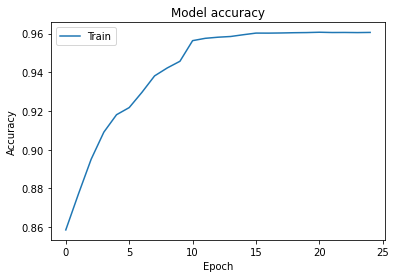

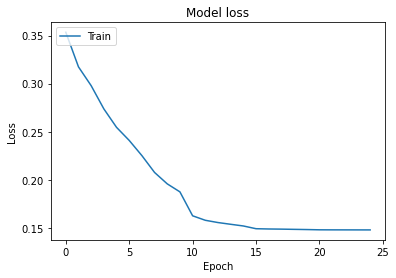

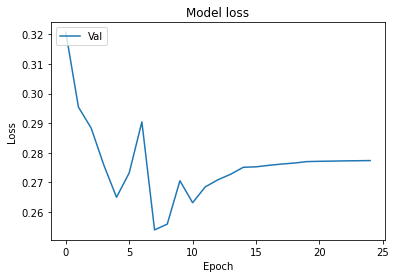

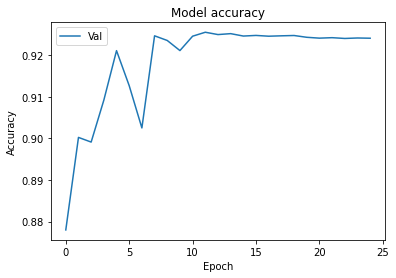

In [25]:
plot_learningCurve(history)

In [26]:
y_pred = model_test.predict(gen_test.test_dataset, verbose=1)

168/168 [==============================] - 52s 307ms/step


In [27]:
# Get true labels from csv file 
y_true_2 = pd.read_csv(config.label_file_path_val).drop('paths', 1)
y_true = np.array([y_true_2.loc[i].to_list() for i in range(len(y_true_2))])
print(y_true)

[[0 0 0 0 1]
 [0 0 0 0 0]
 [0 1 0 0 0]
 ...
 [0 1 0 0 0]
 [0 1 0 0 0]
 [1 0 0 0 1]]


In [28]:
def compare_ytrue_ypred(y_true, y_pred,threshold=0.2):
    for idx in range(len(y_pred)):
        argsort_list = list(np.argsort(np.array(y_pred[idx])))
        argsort_list.reverse()
        true_classes_list = [ i for i in range(len(y_true[idx])) if y_true[idx][i] == 1 ]
        print(f"\n{idx}) True labels:")
        print([label_list[index] for index in true_classes_list])
        pred_labels = []
        for top_matches in argsort_list:
            if y_pred[idx][top_matches] > threshold:
                pred_labels.append(label_list[top_matches])
        print("Predicted labels:")
        print(pred_labels)
#         break
# compare_ytrue_ypred(y_true, y_pred,threshold=0.2)

In [29]:
y_pred_threshold = np.where(y_pred > threshold, 1, 0)

In [30]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.multilabel_confusion_matrix.html
matrices = multilabel_confusion_matrix(y_true, y_pred_threshold)

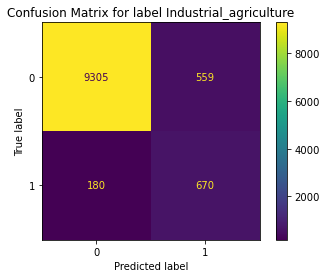

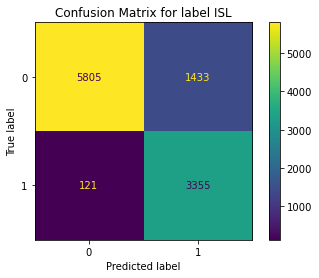

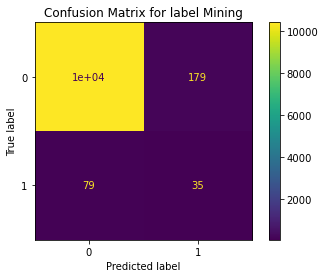

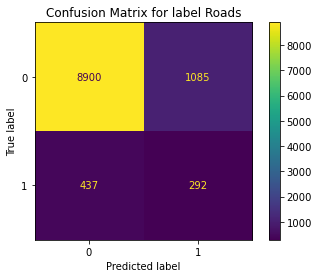

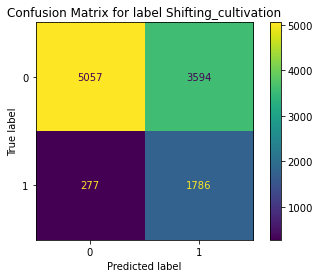

In [31]:
# if no label x on chip i then label = 0 and predicted should = 0 otherwise if label predicted = 1 then it is wrongly classifiying the label (FP)
# if label x on chip i then label = 1 and predicted should = 1 otherwise if label predicted = 0 then it is missing the label classification (FN)
for i in range(len(label_list)):  
    cmd = ConfusionMatrixDisplay(matrices[i], display_labels=np.unique(y_true)).plot()
    plt.title(f'Confusion Matrix for label {label_list[i]}')
    plt.show()

### Test Set

In [34]:
bands = [2, 3, 4, 8, 18]
gen_test = TestDataLoader(label_file_path_test="data/new_test_labels_v2.csv", # or val_all
                data_extension_type='.tif',
                bands=bands,
                augment=config.augment,
                enable_shuffle=config.enable_shuffle,
                batch_size=config.batch_size,
                enable_data_prefetch=True
                )

labels_file_test: data/new_test_labels_v2.csv
test on 71911 images 


In [35]:
model_test.evaluate(gen_test.test_dataset) 

1124/1124 [==============================] - 618s 549ms/step - loss: 0.6277 - accuracy: 0.8065 - precision: 0.3772 - ISL_precision: 0.5405 - recall: 0.3270 - ISL_recall: 0.5265 - f1_score: 0.20634s - loss: 0.6214 - accuracy: 0.8083 - precision: 0.3746 - ISL_precision: 0.5522 - recall: 0.3273 - 


[0.6277146339416504,
 0.8065260648727417,
 0.37722527980804443,
 0.5404810905456543,
 0.3269522488117218,
 0.5265213847160339,
 array([0.008991, 0.541222, 0.067077, 0.238292, 0.176164], dtype=float32)]

In [36]:
y_pred = model_test.predict(gen_test.test_dataset, verbose=1)
# Get true labels from csv file 
y_true_2 = pd.read_csv(config.label_file_path_val).drop('paths', 1)
y_true = np.array([y_true_2.loc[i].to_list() for i in range(len(y_true_2))])
print(y_true)

1124/1124 [==============================] - 652s 580ms/step
[[0 0 0 0 1]
 [0 0 0 0 0]
 [0 1 0 0 0]
 ...
 [0 1 0 0 0]
 [0 1 0 0 0]
 [1 0 0 0 1]]


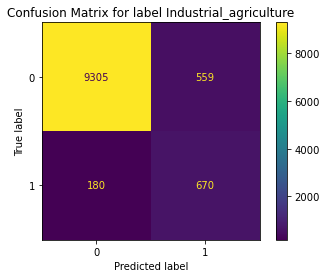

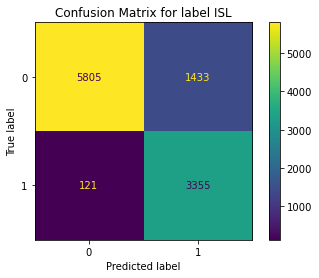

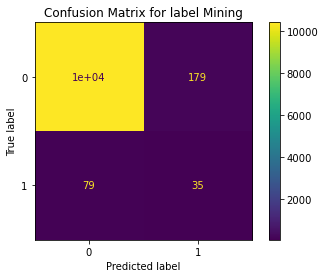

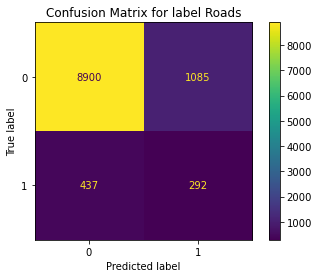

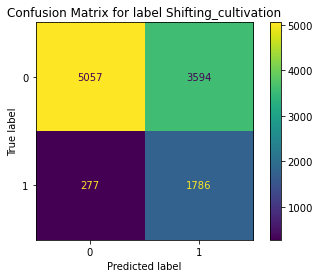

In [37]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.multilabel_confusion_matrix.html
matrices = multilabel_confusion_matrix(y_true, y_pred_threshold)
# if no label x on chip i then label = 0 and predicted should = 0 otherwise if label predicted = 1 then it is wrongly classifiying the label (FP)
# if label x on chip i then label = 1 and predicted should = 1 otherwise if label predicted = 0 then it is missing the label classification (FN)
for i in range(len(label_list)):  
    cmd = ConfusionMatrixDisplay(matrices[i], display_labels=np.unique(y_true)).plot()
    plt.title(f'Confusion Matrix for label {label_list[i]}')
    plt.show()